In [1]:
import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow import feature_column
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import time
import sklearn.preprocessing as skpp
import sklearn.utils

In [4]:
df = pd.read_csv('data/6-gon-lc-04-mesh-dataset-new.csv')

# 2. Separate based on internal nodes added. We choose 2 as it has the highest incidence.
#    -> Remove empty columns with dropna.
#    -> Remove target_edge_length column (experiment)
df = df[df.internal_nodes == 2.0].dropna(axis=1, how='all')
dataset = df[df.target_edge_length == 0.4]
dataset.drop(['target_edge_length', 'internal_nodes'], axis=1)

dataset.shape[0]

71370

In [ ]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1
BATCH_SIZE = 512
EPOCHS = 3000
POLYGON_SIZE = 6

tmp_polygons = pd.read_csv("data/6-gon-lc-04-mesh-dataset-new.csv")
polygons = tmp_polygons.copy()


polygons = sklearn.utils.shuffle(polygons)
# Split dataset into 85/15 training/test
# Later split training into 70/15 train/validation
polygon_train = polygons.sample(frac=0.85, random_state=0)
polygon_test = polygons.drop(polygon_train.index)

train_features = polygon_train.copy()
train_labels = train_features.pop('internal_nodes')

test_features = polygon_test.copy()
test_labels = test_features.pop('internal_nodes')

polygon_model = tf.keras.Sequential([
    tf.keras.Input(shape=(13,)),
    layers.BatchNormalization(),

    layers.Dense(24, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(24, activation='relu')),
    layers.BatchNormalization(),

    layers.Dense(1),
])

polygon_model.summary()
polygon_model.compile(loss = tf.losses.MeanAbsoluteError(),
                      optimizer=tf.optimizers.Adam(
                          learning_rate=LEARNING_RATE, decay=WEIGHT_DECAY
                      ),
                      )

# tensorboard support
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# %tensorboard --logdir logs

history = polygon_model.fit(train_features,
                            train_labels,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_split=0.18,
                            verbose=1,
                            #callbacks=[tensorboard_callback]
                            )

# Evaluate the model
train_acc = polygon_model.evaluate(train_features, train_labels, verbose=0)
test_acc = polygon_model.evaluate(test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' % (train_acc, test_acc))

# plot history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
polygon_model.save('model/saved_model')

In [10]:
tmp_polygons = pd.read_csv("data/6-gon-mesh-dataset.csv")
polygons = tmp_polygons.copy()

# Pre-processing of labels
scaler = skpp.MinMaxScaler()
polygons['internal_nodes'] = scaler.fit_transform(np.array(tmp_polygons['internal_nodes']).reshape(-1, 1))

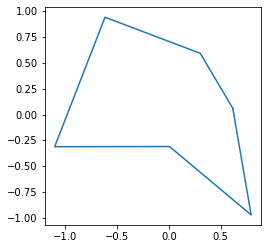

(13,)
[[8.012689]] 2.0


In [28]:
# Generating some examples
import pre_processing as pp
model = tf.keras.models.load_model('model/saved_model')
sample_triangle = pp.procrustes(pp.create_random_ngon(6))



prediction_input = np.append(sample_triangle['transformed_contour'], 0.4)
pp.plot_polygon(sample_triangle['transformed_contour'])
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

print(prediction_input.shape)

internal_node_prediction = model.predict(prediction_input.reshape(-1, 13))  # target_edge_length = 0.4
import gmsh
gmsh.initialize()
actual_value = pp.mesh_contour(sample_triangle['transformed_contour'], 0.4)[-1]
gmsh.finalize()

print(scaler.inverse_transform(internal_node_prediction), actual_value)
